In [1]:
# import libraries ต่าง ๆ ที่จะใช้
import torchviz
import torch
import os
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # ใช้ในการแบ่งข้อมูล
import torch.nn as nn
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from torchmetrics.classification import MulticlassPrecisionRecallCurve
from torch.utils.data import WeightedRandomSampler
import optuna
from optuna.trial import TrialState
from optuna.samplers import TPESampler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
from optuna.integration.tensorboard import TensorBoardCallback
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score

In [2]:
# import dataset
df = pd.read_csv("../3 - Cleaning & Transforming Data/2 cleaned_dataset_MERGED_DRUG(Mogran)_ALLELESEQ.csv", index_col = None)
# assign stratify
df_stratify = pd.DataFrame()
df['ADR'] = df['ADR'].replace({'SJS': 0, 'TEN': 1, 'MPexanthema':2,'MPeruption':3})
df_stratify['ADR'] = df['ADR'].copy()
# drop unnessary columns
df.drop(columns=['No_ADR','ADR','ADR_MPeruption','ADR_MPexanthema','ADR_SJS','ADR_TEN','Cohort ethnicity','Allele','Drug'], inplace=True)

In [3]:
if(df.isna().any().sum()) != 0:
    raise Exception('There are still missing values in the dataset!')

In [4]:
df_stratify['ADR'].value_counts()

0    5805
1    3738
2    1896
3    1634
Name: ADR, dtype: int64

In [5]:
df.dtypes

Cohort ethnicity_Black          int64
Cohort ethnicity_Caucasian      int64
Cohort ethnicity_Diverse        int64
Cohort ethnicity_Mongol         int64
Yes_ADR                       float64
                               ...   
p2-54-S                         int64
p2-54-T                         int64
p2-54-V                         int64
p2-54-W                         int64
p2-54-Y                         int64
Length: 4364, dtype: object

In [6]:
# Select output columns and drop unnecessary columns
df_output = df['Yes_ADR'].copy()
df.drop(columns = ['Yes_ADR'], inplace = True)
df_input = df.copy()
# Check input dtypes
df_input.dtypes.value_counts()

int64    4363
dtype: int64

In [7]:
# Convert to numpy array
np_input = df_input.to_numpy()
np_output = df_output.to_numpy()
np_stratify = df_stratify.to_numpy()

In [8]:
np_input

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [9]:
def get_dataloaders(batch_size):

    # Train Test Splits
    X_train, X_test, y_train, y_test = train_test_split(np_input, np_output, test_size = 0.2, random_state = 128, stratify = np_stratify, shuffle = True)

    # See Distribution
    print('BEFORE applying weight train_label data distribution 0/1: {}/{}'.format(
    len(np.where(y_train == 0)[0]), len(np.where(y_train == 1)[0])))

    print('BEFORE applying weight test_labels data distribution 0/1: {}/{}'.format(
    len(np.where(y_test == 0)[0]), len(np.where(y_test == 1)[0])))

    # Find Weight of each class in train_labels
    weight = (1/pd.DataFrame(y_train).value_counts()).tolist()
    sample_weights = np.array([weight[int(t)] for t in y_train])

    # Create Sampler
    sampler = WeightedRandomSampler(weights=sample_weights,num_samples=len(sample_weights), replacement=True)

    # Create TensorDataset
    train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    test_loader = DataLoader(test_dataset, batch_size=y_test.shape[0])

    return train_loader, test_loader

In [10]:
# Function to check dataloader classes distribution
def get_dataloader_distribution(*args):
    graph_no = len(args)
    fig, ax = plt.subplots(graph_no,1)
    
    for index, dataloader in enumerate(args):
        batch_no = [x+1 for x in range(len(dataloader))]
        class_0_count = []
        class_1_count = []
        batch_count = []

        for i, (data,target) in enumerate(dataloader):
            tocount = pd.DataFrame(target.numpy()).value_counts()
            batch_count.append(i+1)
            class_0_count.append(tocount[0.0])
            class_1_count.append(tocount[1.0])

        X_axis = np.arange(len(batch_count))

        
        fig.set_figwidth(15)
        fig.set_figheight(10)
        ax[index].set_xlabel="Batch Number"
        ax[index].set_ylabel="No. Datapoints"
        ax[index].bar(X_axis,class_0_count,width=(1/3) ,label = "NoADR",color='green',alpha=0.5)
        ax[index].bar(X_axis+(1/3),class_1_count,width=(1/3), label = 'ADR',color='red',alpha=0.5)
        #ax.set_xticks(X_axis+width)
        ax[index].legend()

        ax[index].set_title(f"{dataloader} Data Distribution")
    fig.show()

In [11]:
# Define the model hyperparameters
classes = 1
batch_size = 128 
LEARNING_RATE = 2e-5 
DROPOUT_RATE = 0.2
L2lambda = 1e-2
EPOCHS = 1000
DIR = os.getcwd()
dirname = "optuna_study6(wide_final)" 
#train_loader, test_loader = get_dataloaders(batch_size)
loss_fn = nn.BCELoss() 
#get_dataloader_distribution(train_loader,test_loader)

c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:175: ExperimentalWarning: TensorBoardCallback is experimental (supported from v2.0.0). The interface can change in the future.
[I 2023-04-15 16:18:23,152] Using an existing study with name 'optuna_study6(wide_final)' instead of creating a new one.


BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Sequential(
  (0): Linear(in_features=4363, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.17637723026852012, inplace=False)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.17637723026852012, inplace=False)
  (6): Linear(in_features=256, out_features=1, bias=True)
  (7): Sigmoid()
)
epoch0, train accuracy: 0.5578095684756097, test accuracy:0.6248565965583174 train loss:0.68897809, test loss:0.67747945, test precision: 0.4802981895633653,test recall: 0.4777542372881356,test f1: 0.4790228359001593


[I 2023-04-15 16:18:28,743] Trial 234 pruned. 


epoch1, train accuracy: 0.5905033419512196, test accuracy:0.6065009560229445 train loss:0.67987078, test loss:0.66917551, test precision: 0.6560170394036209,test recall: 0.4659606656580938,test f1: 0.5448916408668731
BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Sequential(
  (0): Linear(in_features=4363, out_features=1024, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=256, out_features=128, bias=True)
  (10): ReLU()
  (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=128, out_features=64, bias=True)
  (13): ReLU()
  (14): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Linear(in_features=64, out_features=32, bias=True)
  (16): ReLU()
  (17): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (18): L

[I 2023-04-15 16:18:31,457] Trial 235 pruned. 


epoch1, train accuracy: 0.6679906019512195, test accuracy:0.682982791586998 train loss:0.60891755, test loss:0.62437147, test precision: 0.6059637912673056,test recall: 0.5535019455252919,test f1: 0.5785460091509913
BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Sequential(
  (0): Linear(in_features=4363, out_features=256, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=64, out_features=32, bias=True)
  (10): ReLU()
  (11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=32, out_features=16, bias=True)
  (13): ReLU()
  (14): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Linear(in_features=16, out_features=1, bias=True)
  (16): Sigmoid()
)
epoch0, train accuracy: 0.6315760501219512, test accuracy:0.6481835564053537 train loss:0.64064254, te

[I 2023-04-15 16:18:44,295] Trial 236 pruned. 


epoch9, train accuracy: 0.663808435, test accuracy:0.6906309751434034 train loss:0.61168549, test loss:0.60299444, test precision: 0.5686900958466453,test recall: 0.5692963752665245,test f1: 0.568993074054342
BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Sequential(
  (0): Linear(in_features=4363, out_features=1024, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=256, out_features=128, bias=True)
  (10): ReLU()
  (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=128, out_features=1, bias=True)
  (13): Sigmoid()
)
epoch0, train accuracy: 0.6443682248780488, test accuracy:0.6952198852772467 train loss:0.63024929, test loss:0.60471421, test precision: 0.5857294994675186,test recall: 0.5741127348643006,test f1: 0.5798629414865578
epoch1, train accuracy: 0.663918529756

[I 2023-04-15 16:18:56,665] Trial 237 pruned. 


epoch9, train accuracy: 0.6709243732926828, test accuracy:0.6917782026768643 train loss:0.60026469, test loss:0.59007025, test precision: 0.5804046858359957,test recall: 0.5694879832810867,test f1: 0.5748945147679324
BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Sequential(
  (0): Linear(in_features=4363, out_features=4096, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=4096, out_features=2048, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=2048, out_features=1024, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=1024, out_features=512, bias=True)
  (10): ReLU()
  (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=512, out_features=256, bias=True)
  (13): ReLU()
  (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Linear(in_features=256, out_features=128, bias=True)
  (16): ReLU()
  (17): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

[I 2023-04-15 16:19:35,246] Trial 238 pruned. 


epoch3, train accuracy: 0.6552575864525995, test accuracy:0.6680688336520076 train loss:0.62124136, test loss:0.62324691, test precision: 0.5867944621938233,test recall: 0.5344325897187197,test f1: 0.5593908629441624
BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Sequential(
  (0): Linear(in_features=4363, out_features=2048, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2670084803562565, inplace=False)
  (3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=2048, out_features=1024, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2670084803562565, inplace=False)
  (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Linear(in_features=1024, out_features=512, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.2670084803562565, inplace=False)
  (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=512, out_features=256, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.2670084803562565, inplace=False)
  (15): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): Linear(in_features=256, out_features=128, bias=True)
  (17): ReLU()
  (18): Dropout(p=0.2670084803562565, inpla

[I 2023-04-15 16:21:06,396] Trial 239 pruned. 


epoch27, train accuracy: 0.646414751402439, test accuracy:0.6883365200764818 train loss:0.63332834, test loss:0.61460257, test precision: 0.5218317358892439,test recall: 0.572429906542056,test f1: 0.5459610027855152
BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Sequential(
  (0): Linear(in_features=4363, out_features=2048, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.22532483337329526, inplace=False)
  (3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=2048, out_features=1024, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.22532483337329526, inplace=False)
  (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Linear(in_features=1024, out_features=512, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.22532483337329526, inplace=False)
  (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=512, out_features=256, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.22532483337329526, inplace=False)
  (15): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): Linear(in_features=256, out_features=128, bias=True)
  (17): ReLU()
  (18): Dropout(p=0.22532483337329526, 

[I 2023-04-15 16:21:12,360] Trial 240 pruned. 


epoch3, train accuracy: 0.5709636873170731, test accuracy:0.6565965583173996 train loss:0.69079691, test loss:0.62975776, test precision: 0.4579339723109691,test recall: 0.525030525030525,test f1: 0.4891922639362912
BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Sequential(
  (0): Linear(in_features=4363, out_features=2048, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2048, out_features=1024, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=1, bias=True)
  (7): Sigmoid()
)
epoch0, train accuracy: 0.5700706496341463, test accuracy:0.6026768642447419 train loss:0.68006195, test loss:0.65949857, test precision: 0.5750798722044729,test recall: 0.4576271186440678,test f1: 0.5096743747050495
epoch1, train accuracy: 0.5993711890243902, test accuracy:0.6260038240917782 train loss:0.65954747, test loss:0.65122086, test precision: 0.5899893503727369,test recall: 0.48299912816041846,test f1: 0.5311601150527324
epoch2, train accuracy: 0.598425773902439, test accuracy:0.6290630975143403 train loss:0.65138059, test loss:0.64765346, test precision: 0.5889243876464324,test recall: 0.48636763412489004,test f1: 0.5327552986512525
epoch3, train accuracy: 0.604647

[I 2023-04-15 16:52:32,207] Trial 241 finished with value: 0.5860918872966999 and parameters: {'batch_size': 64, 'batch_norm': 'no', 'dropout': 'no', 'weightdecay': 'no', 'n_layers': 2, 'n_first_units': 2048, 'optimizer': 'Adam', 'lr': 2.062382956058413e-05}. Best is trial 45 with value: 0.5748247390701657.


BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Sequential(
  (0): Linear(in_features=4363, out_features=256, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=64, out_features=1, bias=True)
  (10): Sigmoid()
)
epoch0, train accuracy: 0.5558641528571429, test accuracy:0.5292543021032505 train loss:0.7046155, test loss:0.71447742, test precision: 0.7433439829605963,test recall: 0.41350710900473936,test f1: 0.5314046440807005
epoch1, train accuracy: 0.5665982352380953, test accuracy:0.4868068833652008 train loss:0.69229943, test loss:0.71185142, test precision: 0.46325878594249204,test recall: 0.34171249018067557,test f1: 0.3933092

[I 2023-04-15 16:52:35,965] Trial 242 pruned. 


epoch3, train accuracy: 0.5952961157142858, test accuracy:0.6340344168260038 train loss:0.67031064, test loss:0.65345073, test precision: 0.5079872204472844,test recall: 0.49074074074074076,test f1: 0.4992150706436421
BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Sequential(
  (0): Linear(in_features=4363, out_features=4096, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4096, out_features=2048, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2048, out_features=1, bias=True)
  (5): Sigmoid()
)
epoch0, train accuracy: 0.5731664973170731, test accuracy:0.6038240917782027 train loss:0.68773145, test loss:0.67973644, test precision: 0.6975505857294995,test recall: 0.46552949538024163,test f1: 0.5583972719522592
epoch1, train accuracy: 0.582638888902439, test accuracy:0.5108986615678777 train loss:0.68075824, test loss:0.67723107, test precision: 0.8019169329073482,test recall: 0.4079089924160347,test f1: 0.5407540394973069
epoch2, train accuracy: 0.5817560129268293, test accuracy:0.6187380497131931 train loss:0.67614704, test loss:0.66618806, test precision: 0.5782747603833865,test recall: 0.47465034965034963,test f1: 0.5213634181469035


[I 2023-04-15 16:52:45,475] Trial 243 pruned. 


epoch3, train accuracy: 0.5854717141463415, test accuracy:0.6007648183556406 train loss:0.67194727, test loss:0.666614, test precision: 0.6080937167199149,test recall: 0.4578989574979952,test f1: 0.5224153705397988
BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Sequential(
  (0): Linear(in_features=4363, out_features=4096, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=4096, out_features=2048, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=2048, out_features=1024, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=1024, out_features=512, bias=True)
  (10): ReLU()
  (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=512, out_features=256, bias=True)
  (13): ReLU()
  (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Linear(in_features=256, out_features=128, bias=True)
  (16): ReLU()
  (17): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

[I 2023-04-15 16:52:49,194] Trial 244 pruned. 


epoch1, train accuracy: 0.6629737338095238, test accuracy:0.6068833652007648 train loss:0.60438454, test loss:0.67591691, test precision: 0.6091586794462194,test recall: 0.46390916463909165,test f1: 0.5267034990791897
BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Sequential(
  (0): Linear(in_features=4363, out_features=2048, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2048, out_features=1024, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=1, bias=True)
  (7): Sigmoid()
)
epoch0, train accuracy: 0.577172256097561, test accuracy:0.524282982791587 train loss:0.68106835, test loss:0.66786391, test precision: 0.7380191693290735,test recall: 0.4098166765227676,test f1: 0.5269961977186312
epoch1, train accuracy: 0.6105989094512194, test accuracy:0.6263862332695985 train loss:0.65916327, test loss:0.6468308, test precision: 0.5985090521831736,test recall: 0.4836488812392427,test f1: 0.5349833412660638
epoch2, train accuracy: 0.6136989915853659, test accuracy:0.6325047801147228 train loss:0.65202265, test loss:0.63813066, test precision: 0.5239616613418531,test recall: 0.48906560636182905,test f1: 0.5059125964010284
epoch3, train accuracy: 0.614417213

[I 2023-04-15 18:25:19,293] Trial 245 pruned. 


epoch729, train accuracy: 0.6891563086585366, test accuracy:0.6933078393881453 train loss:0.56953541, test loss:0.5917989, test precision: 0.6293929712460063,test recall: 0.5655502392344498,test f1: 0.5957661290322581
BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Sequential(
  (0): Linear(in_features=4363, out_features=1024, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=256, out_features=128, bias=True)
  (10): ReLU()
  (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=128, out_features=64, bias=True)
  (13): ReLU()
  (14): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Linear(in_features=64, out_features=32, bias=True)
  (16): ReLU()
  (17): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (18): L

[I 2023-04-15 18:25:33,839] Trial 246 pruned. 


epoch9, train accuracy: 0.6745356902439025, test accuracy:0.7009560229445506 train loss:0.60334153, test loss:0.60024142, test precision: 0.5431309904153354,test recall: 0.5909617612977984,test f1: 0.5660377358490566
BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Sequential(
  (0): Linear(in_features=4363, out_features=4096, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=4096, out_features=2048, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=2048, out_features=1024, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=1024, out_features=512, bias=True)
  (10): ReLU()
  (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=512, out_features=256, bias=True)
  (13): ReLU()
  (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Linear(in_features=256, out_features=1, bias=True)
  (16): Sigmoid()
)
epoch0, train accuracy: 0.619593815, test accuracy:0.6409177820267686 train loss:0.6

[I 2023-04-15 18:25:37,038] Trial 247 pruned. 


epoch1, train accuracy: 0.6636503733333333, test accuracy:0.6409177820267686 train loss:0.60752884, test loss:0.66827416, test precision: 0.0,test recall: 0.0,test f1: 0.0
BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Sequential(
  (0): Linear(in_features=4363, out_features=2048, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=2048, out_features=1024, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=1024, out_features=512, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=512, out_features=256, bias=True)
  (10): ReLU()
  (11): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=256, out_features=128, bias=True)
  (13): ReLU()
  (14): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Linear(in_features=128, out_features=64, bias=True)
  (16): ReLU()
  (17): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (

[I 2023-04-15 18:25:42,043] Trial 248 pruned. 


epoch3, train accuracy: 0.6644156270731707, test accuracy:0.6692160611854685 train loss:0.60533879, test loss:0.60200542, test precision: 0.6091586794462194,test recall: 0.5345794392523364,test f1: 0.5694375311100051
BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Sequential(
  (0): Linear(in_features=4363, out_features=4096, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2158656211646971, inplace=False)
  (3): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=4096, out_features=2048, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2158656211646971, inplace=False)
  (7): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Linear(in_features=2048, out_features=1, bias=True)
  (9): Sigmoid()
)
epoch0, train accuracy: 0.5899829971951219, test accuracy:0.675717017208413 train loss:0.67668785, test loss:0.60500568, test precision: 0.48668796592119273,test recall: 0.5552855407047388,test f1: 0.5187287173666288
epoch1, train accuracy: 0.6131493315853659, test accuracy:0.6795411089866157 train loss:0.66258421, test loss:0.6003716, test precision: 0.4728434504792332,test recall: 0.5641677255400254,test f1: 0.5144843568945539
epoch2, train accuracy: 0.6240765712804879,

[I 2023-04-15 18:25:58,375] Trial 249 pruned. 


epoch3, train accuracy: 0.6294046083536586, test accuracy:0.6776290630975144 train loss:0.643658, test loss:0.60677588, test precision: 0.56975505857295,test recall: 0.5492813141683778,test f1: 0.5593308938839519
BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Sequential(
  (0): Linear(in_features=4363, out_features=4096, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.20744593996944702, inplace=False)
  (3): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=4096, out_features=2048, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.20744593996944702, inplace=False)
  (7): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Linear(in_features=2048, out_features=1, bias=True)
  (9): Sigmoid()
)
epoch0, train accuracy: 0.6096461655487805, test accuracy:0.6504780114722754 train loss:0.67836712, test loss:0.63727456, test precision: 0.5005324813631523,test recall: 0.5136612021857924,test f1: 0.5070118662351673
epoch1, train accuracy: 0.6257988391463415, test accuracy:0.6776290630975144 train loss:0.65129621, test loss:0.60406077, test precision: 0.5889243876464324,test recall: 0.5475247524752476,test f1: 0.5674704976911238
epoch2, train accuracy: 0.62226635786585

[I 2023-04-15 18:26:14,273] Trial 250 pruned. 


epoch3, train accuracy: 0.6211303940243903, test accuracy:0.6803059273422563 train loss:0.65264766, test loss:0.64107889, test precision: 0.4984025559105431,test recall: 0.5618247298919568,test f1: 0.5282167042889391
BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Sequential(
  (0): Linear(in_features=4363, out_features=4096, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=4096, out_features=2048, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=2048, out_features=1024, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=1024, out_features=512, bias=True)
  (10): ReLU()
  (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=512, out_features=256, bias=True)
  (13): ReLU()
  (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Linear(in_features=256, out_features=128, bias=True)
  (16): ReLU()
  (17): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

[I 2023-04-15 18:26:31,095] Trial 251 pruned. 


epoch9, train accuracy: 0.6803762726829268, test accuracy:0.675717017208413 train loss:0.59109927, test loss:0.60254973, test precision: 0.625133120340788,test recall: 0.5420129270544783,test f1: 0.5806132542037586
BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


Sequential(
  (0): Linear(in_features=4363, out_features=4096, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=4096, out_features=2048, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=2048, out_features=1024, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=1024, out_features=512, bias=True)
  (10): ReLU()
  (11): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=512, out_features=256, bias=True)
  (13): ReLU()
  (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Linear(in_features=256, out_features=128, bias=True)
  (16): ReLU()
  (17): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

[I 2023-04-15 18:26:47,502] Trial 252 pruned. 


epoch9, train accuracy: 0.6739518068292684, test accuracy:0.6783938814531548 train loss:0.59736812, test loss:0.6167655, test precision: 0.5953141640042598,test recall: 0.5480392156862746,test f1: 0.5706993363961205
Study statistics: 
  Number of finished trials:  253
  Number of pruned trials:  238
  Number of complete trials:  12
Best trial:
  Value:  0.5748247390701657
  Params: 
    L2lambda: 0.0026570435599015596
    batch_norm: yes
    batch_size: 512
    dropout: no
    lr: 6.801301238867615e-05
    n_first_units: 512
    n_layers: 4
    optimizer: Adam
    weightdecay: yes


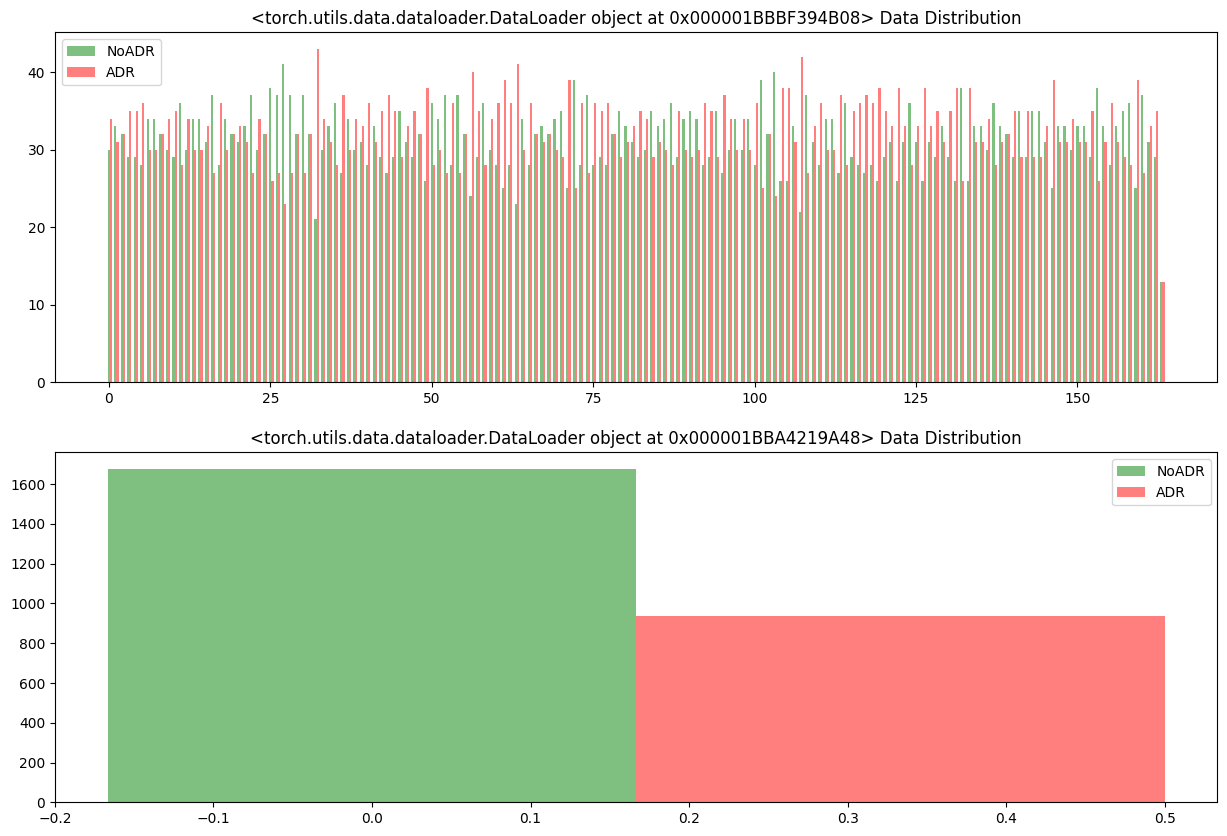

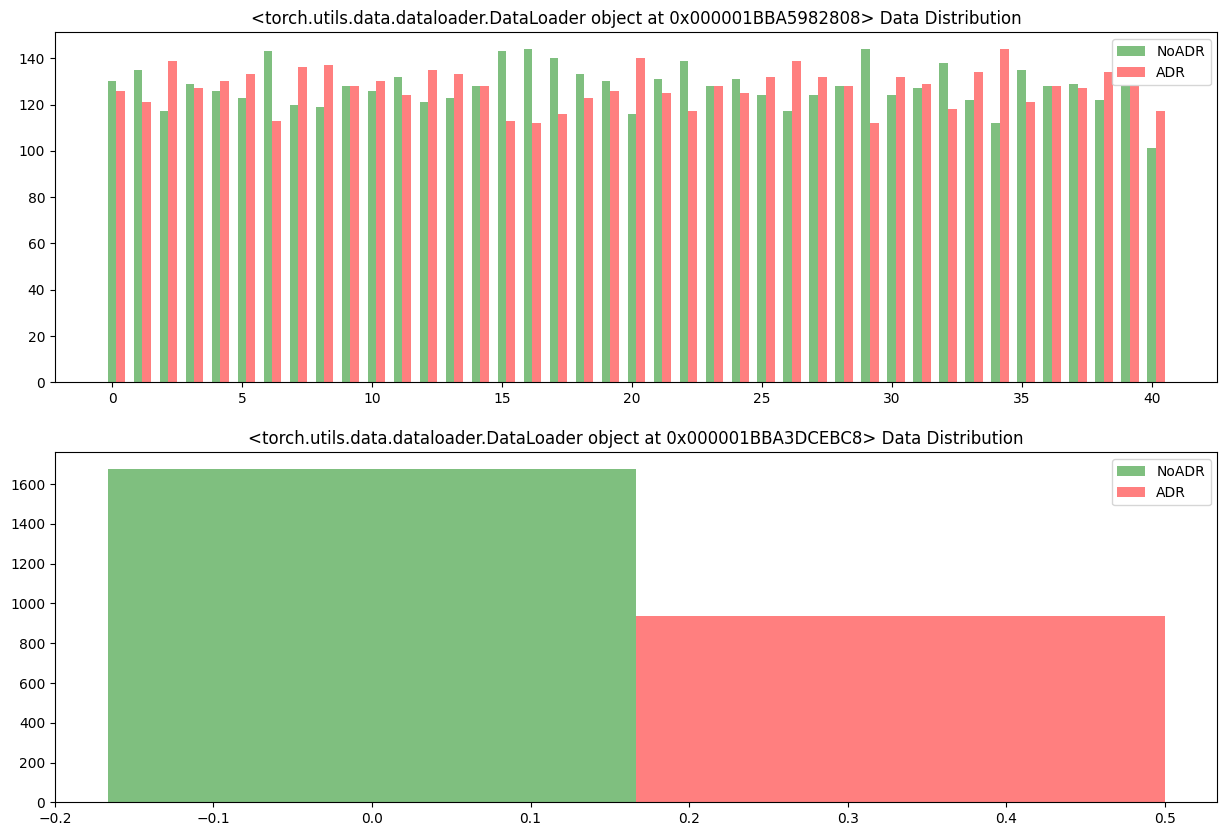

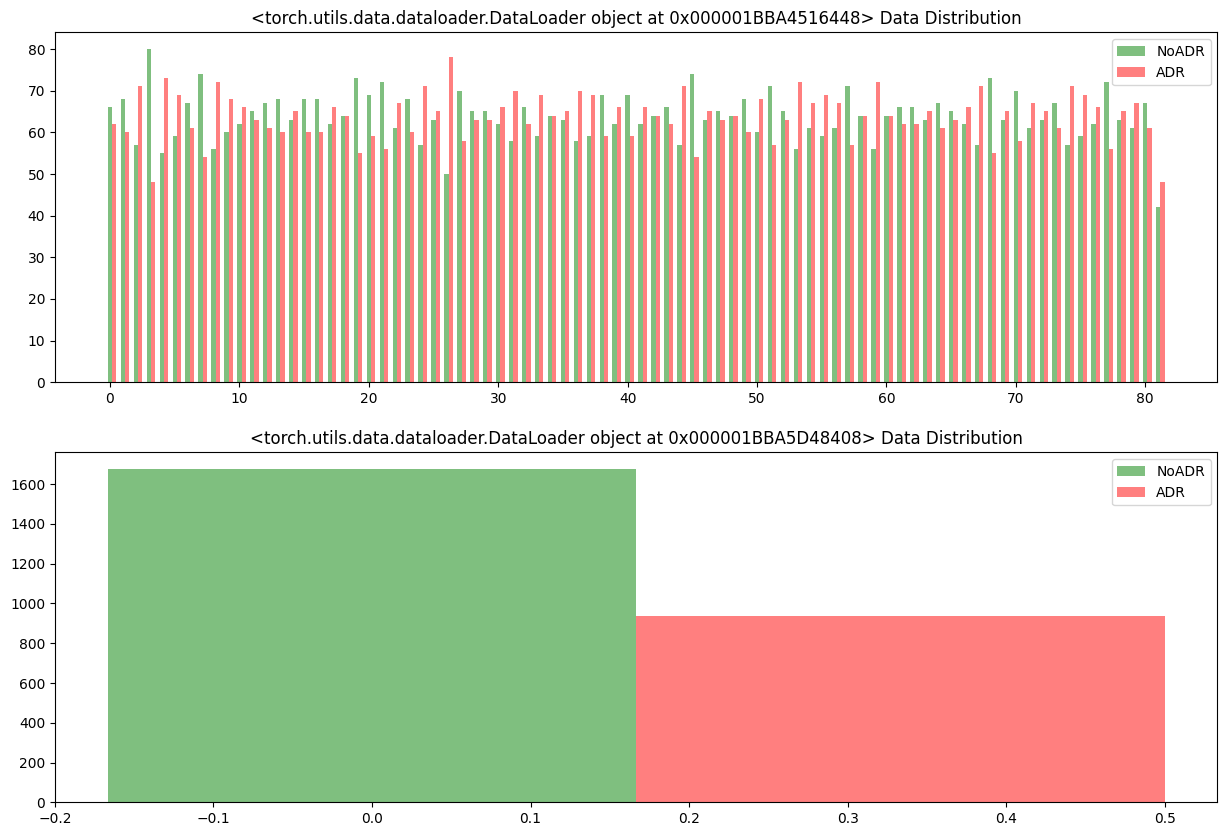

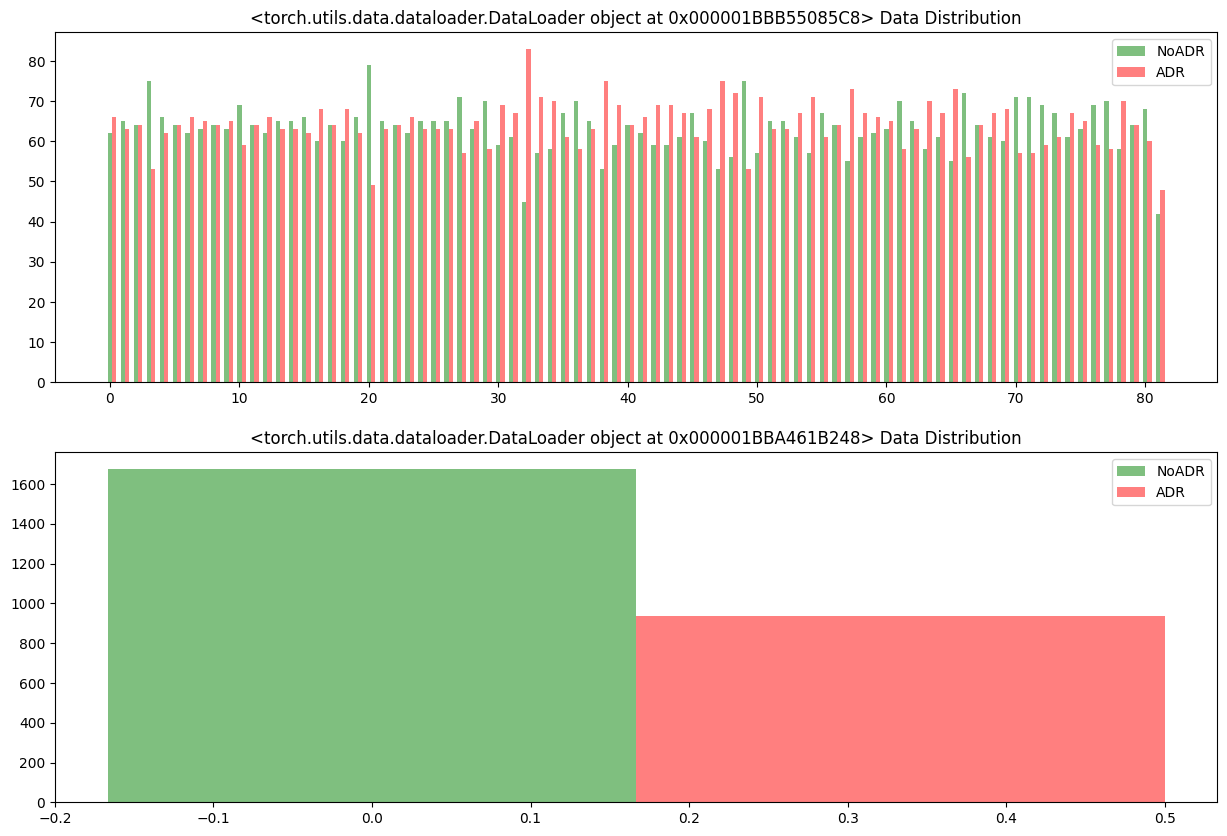

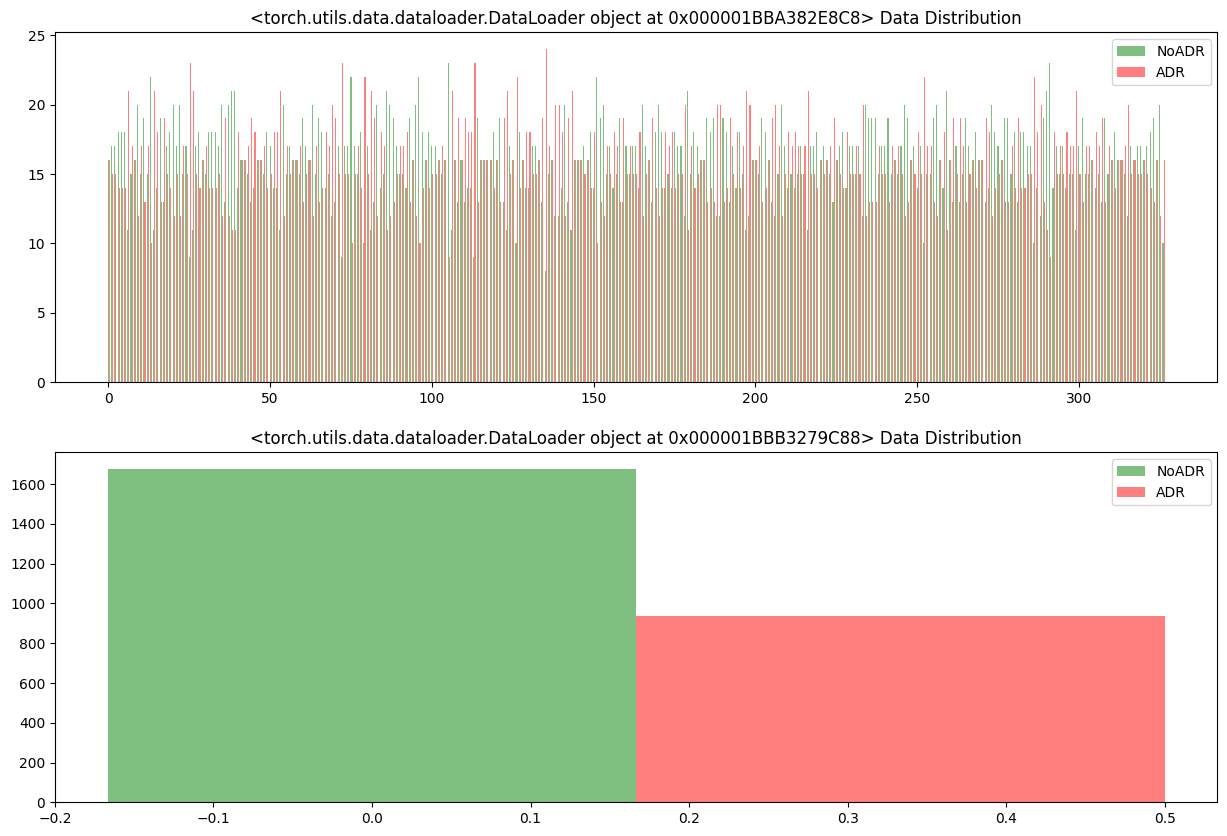

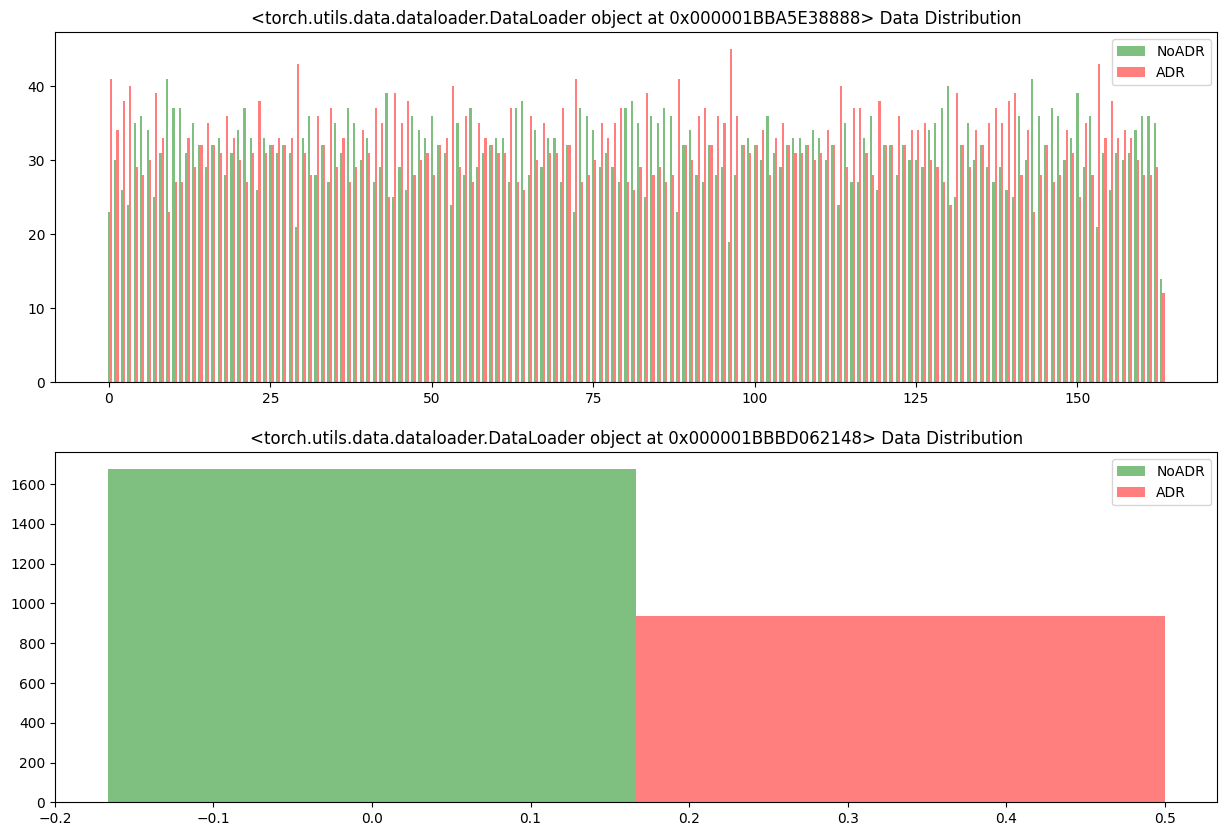

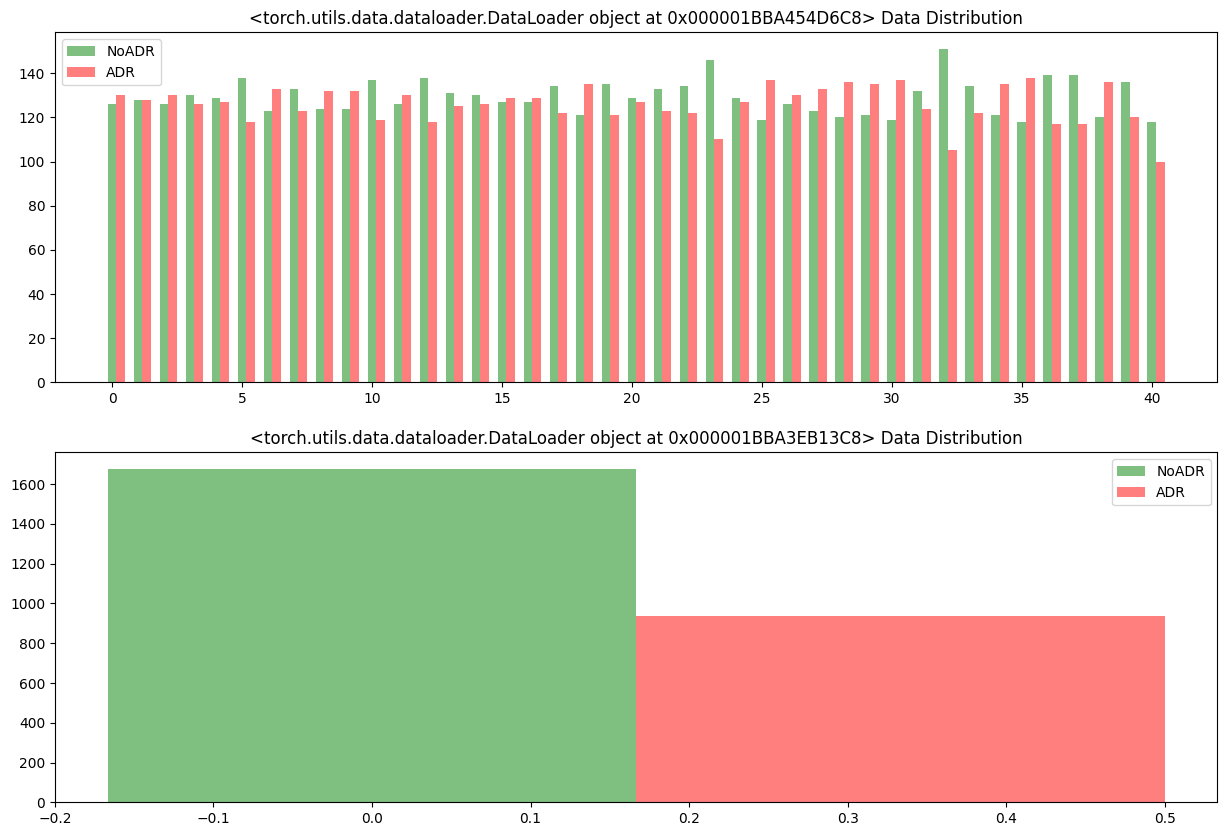

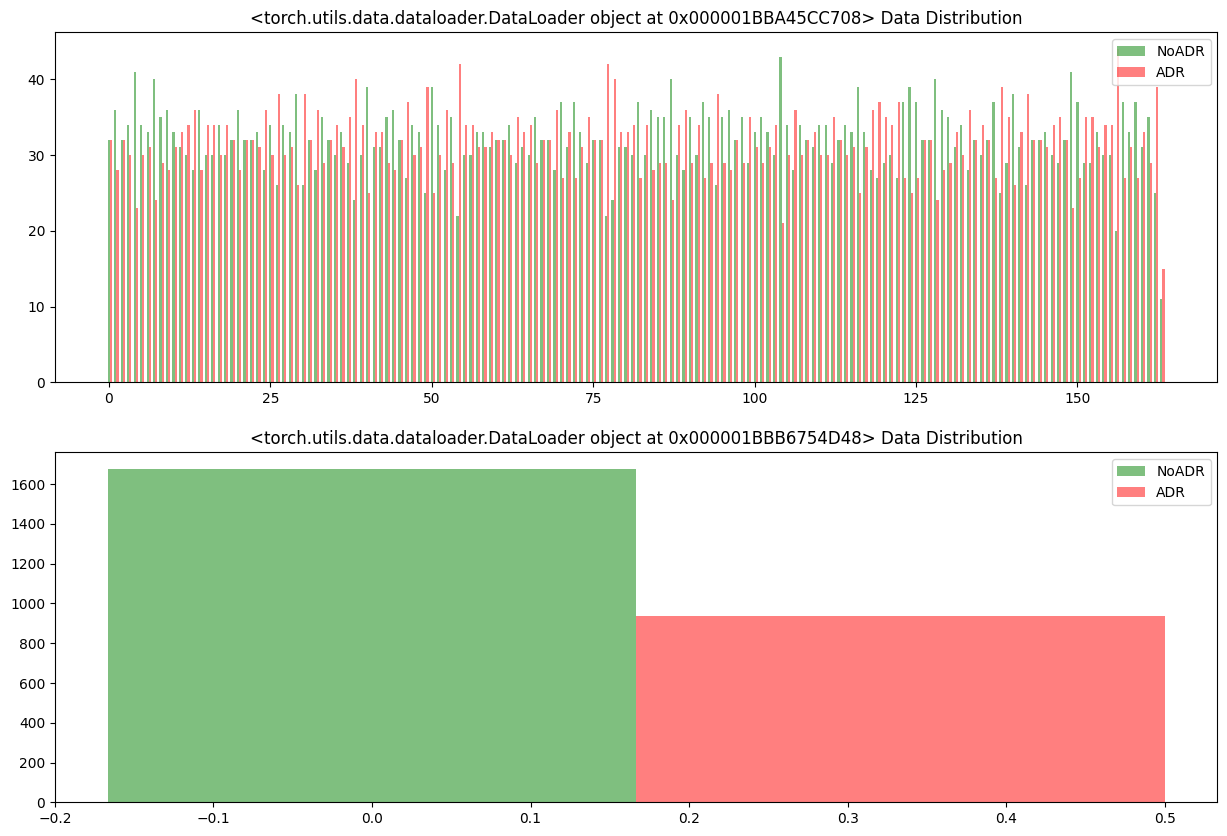

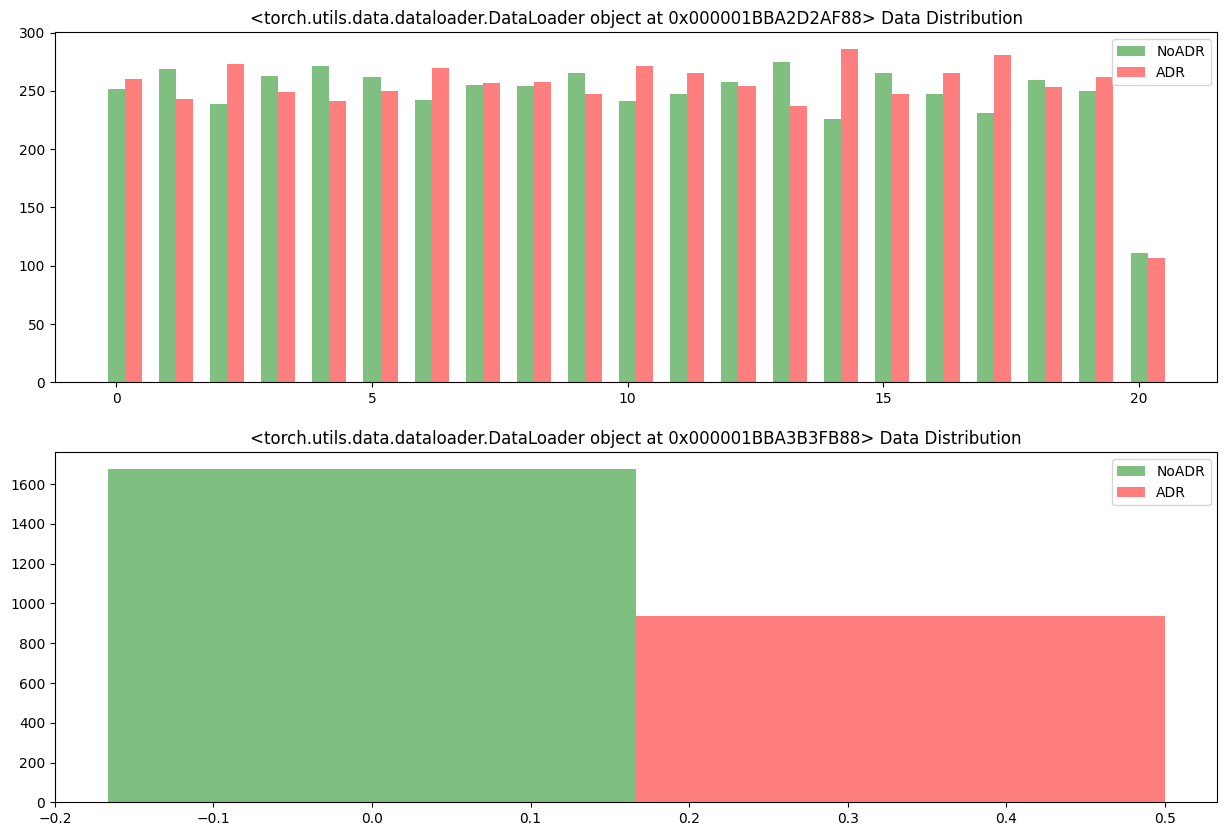

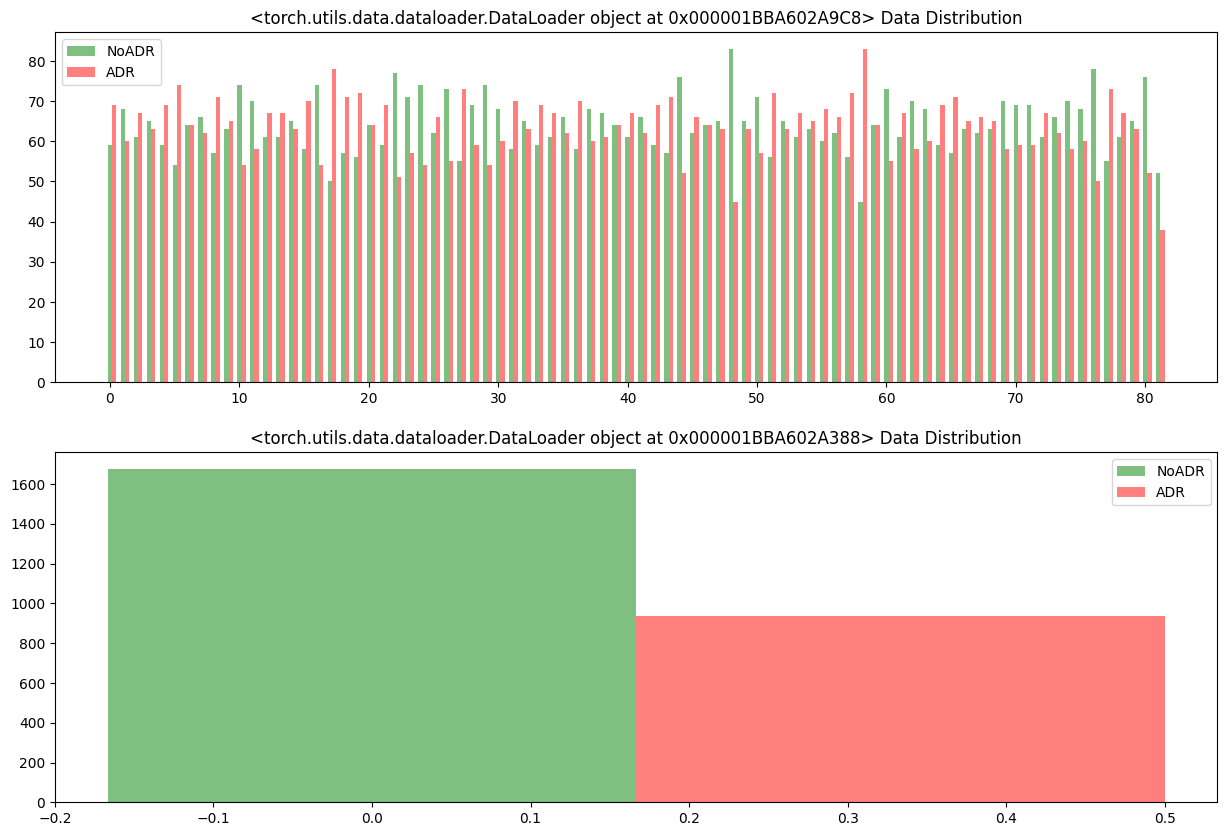

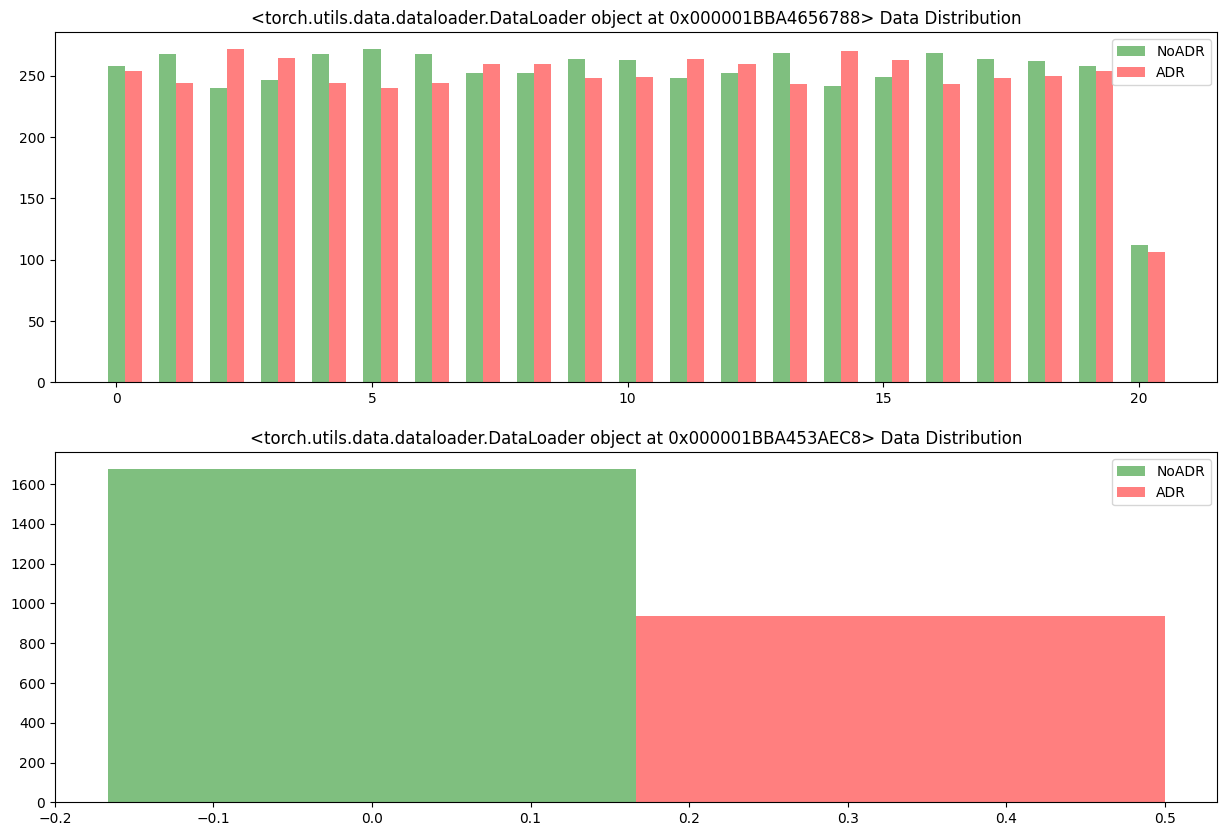

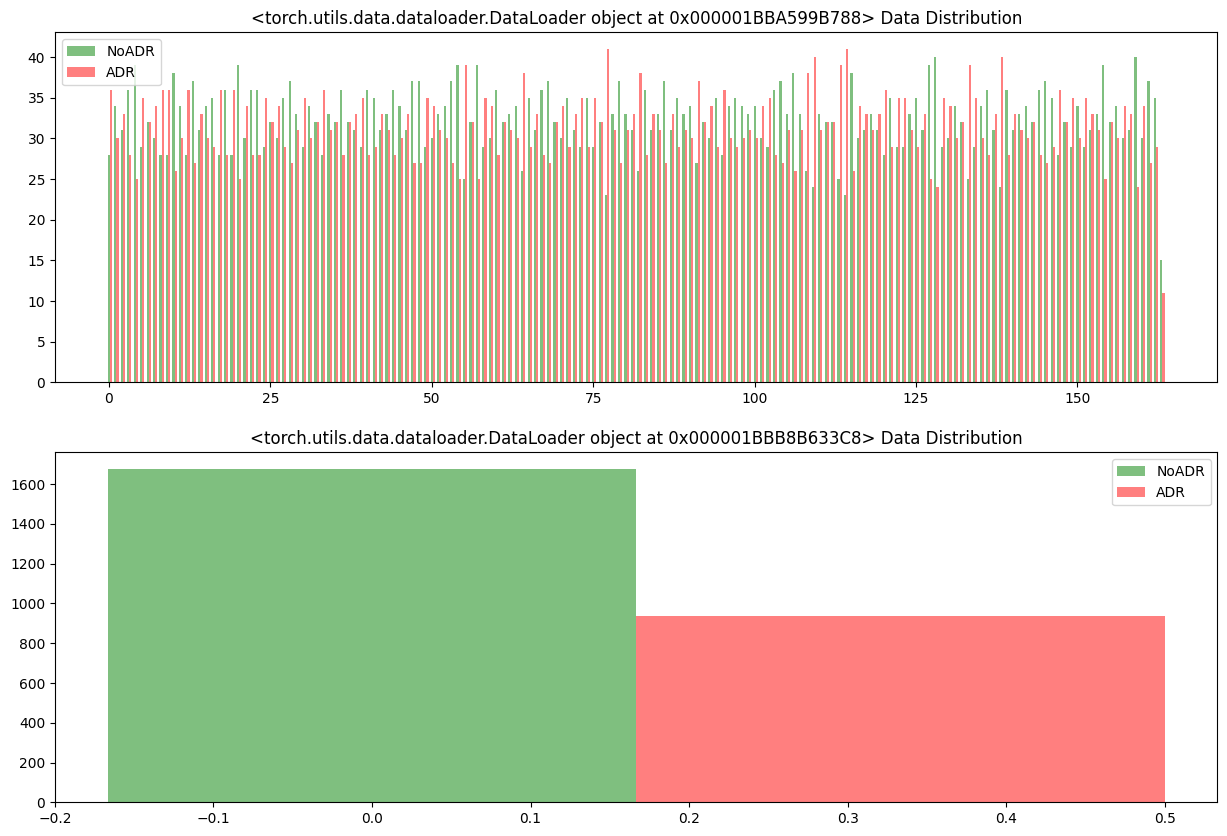

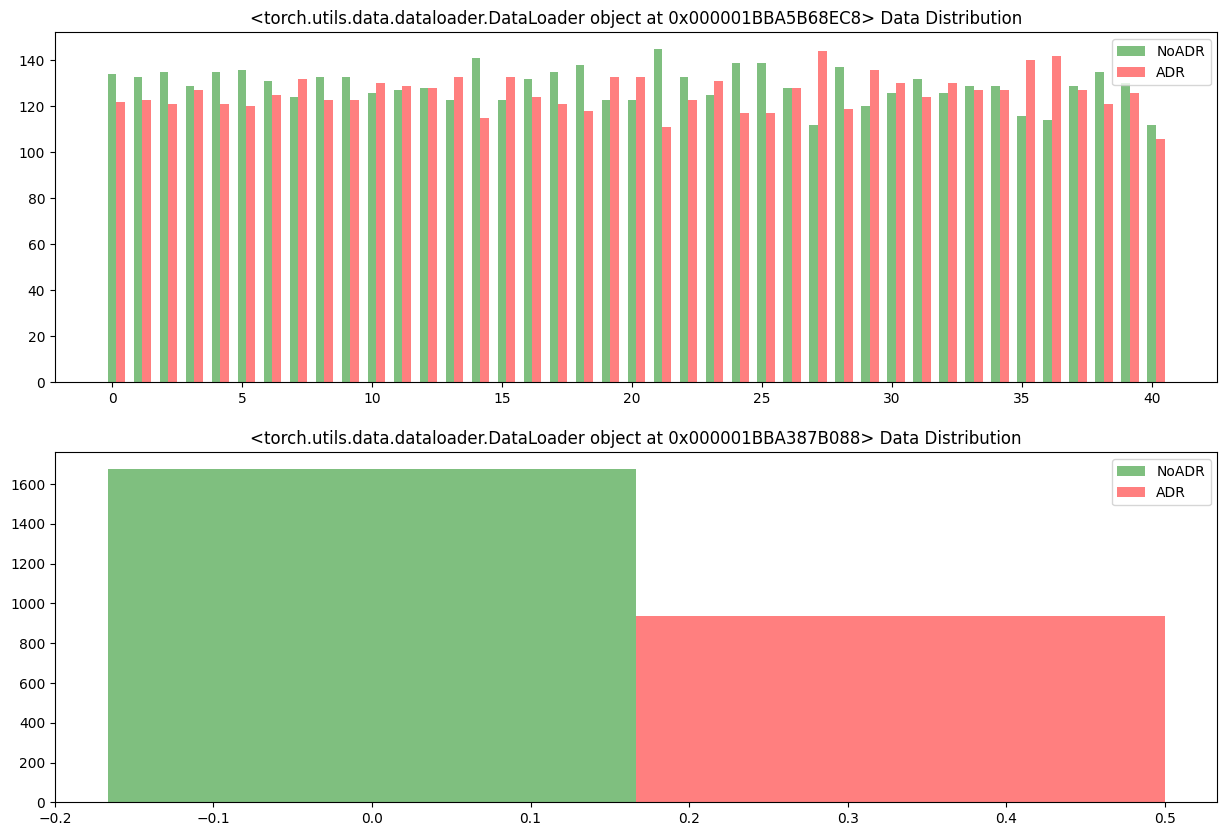

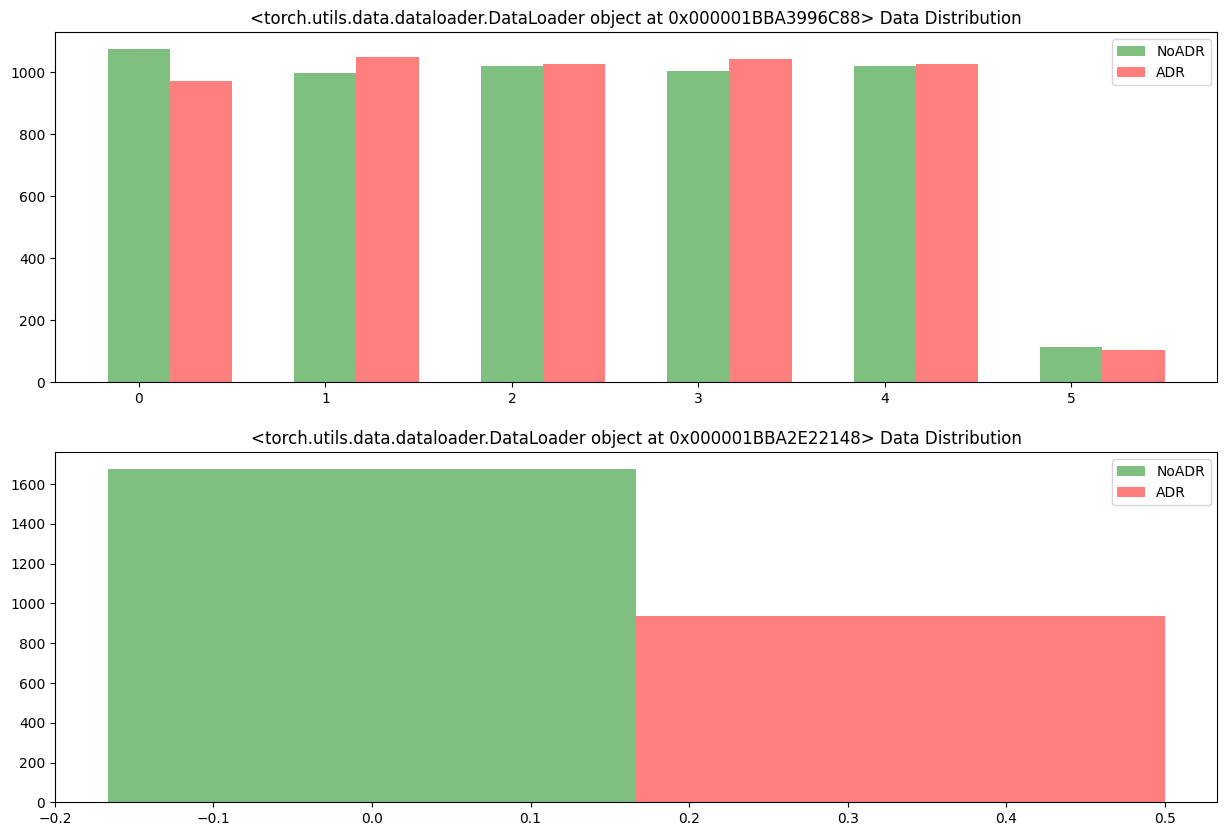

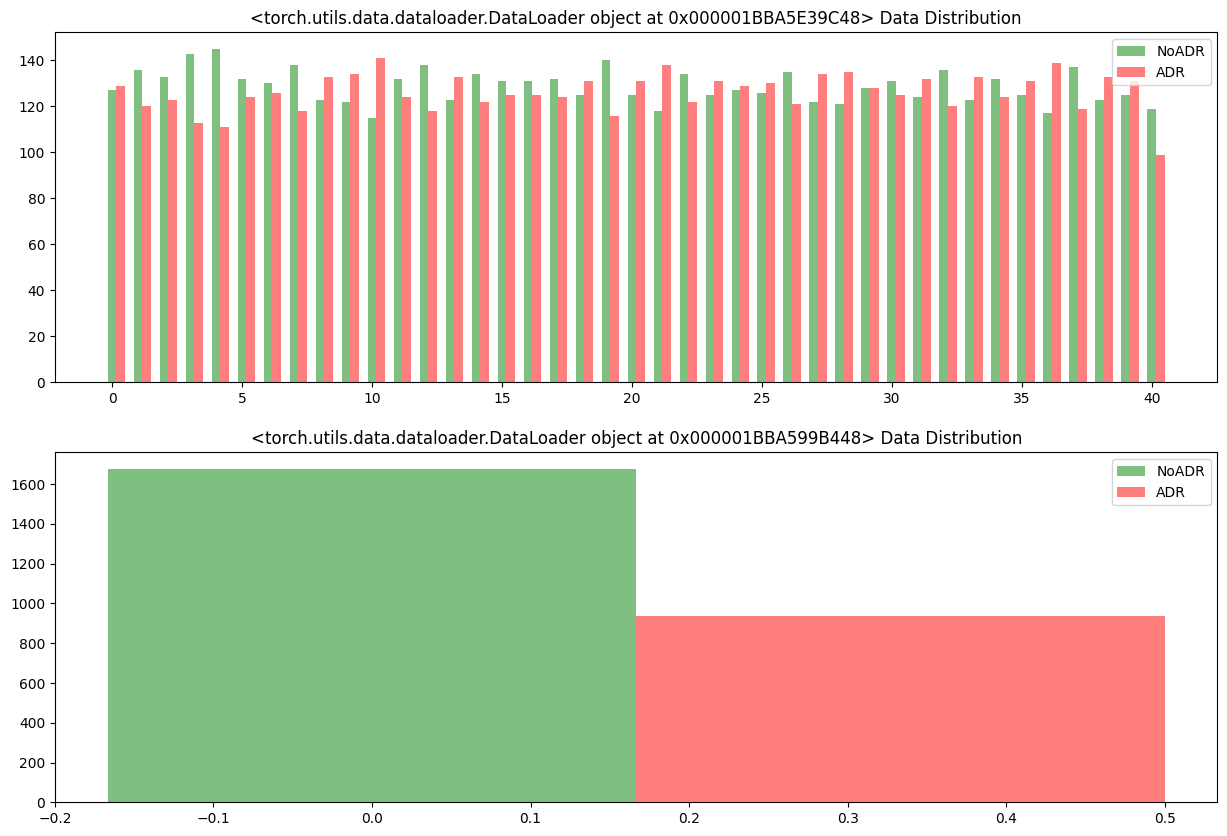

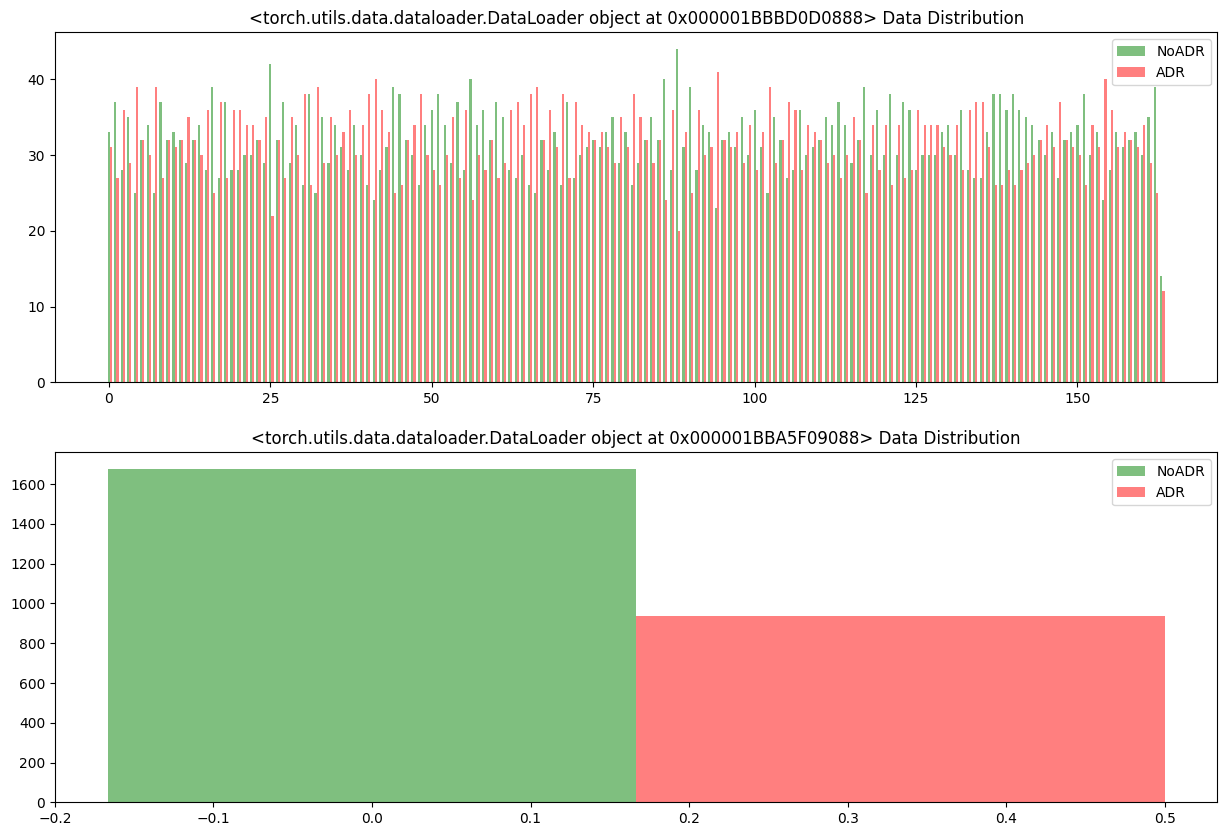

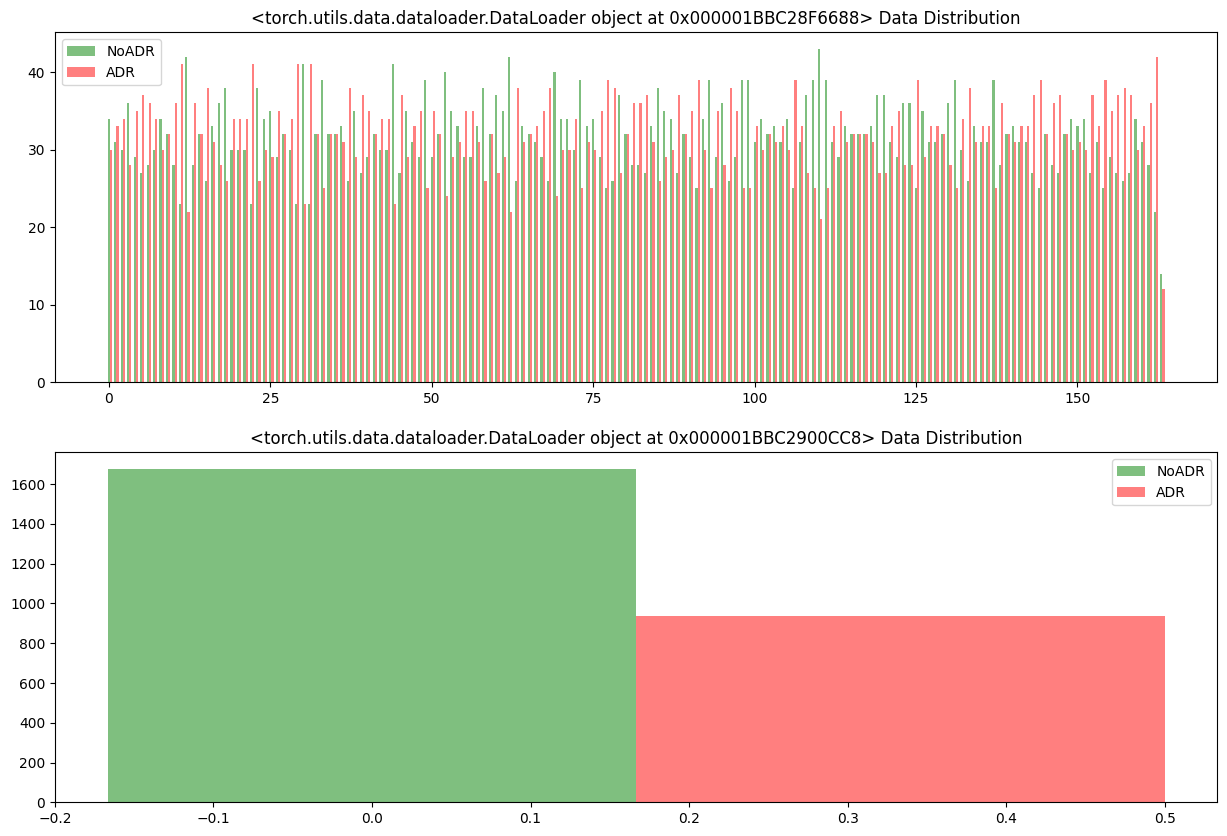

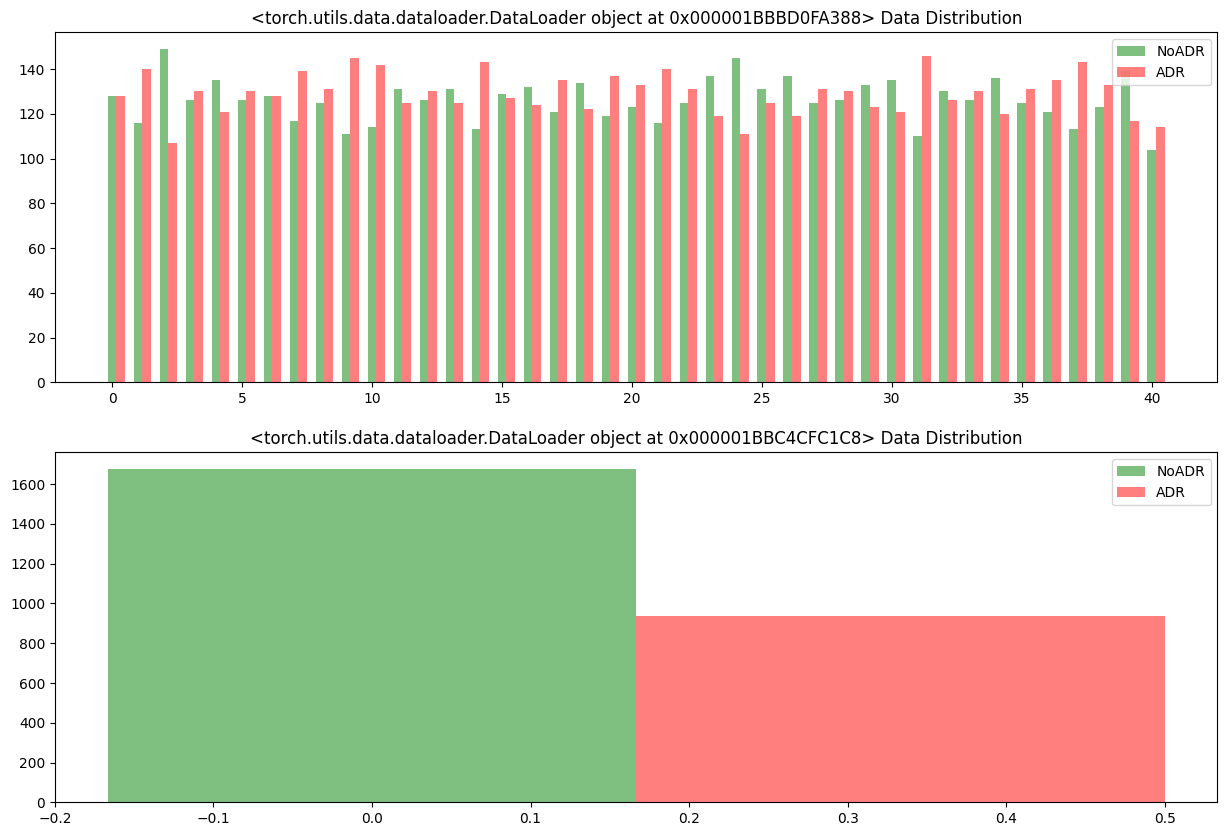

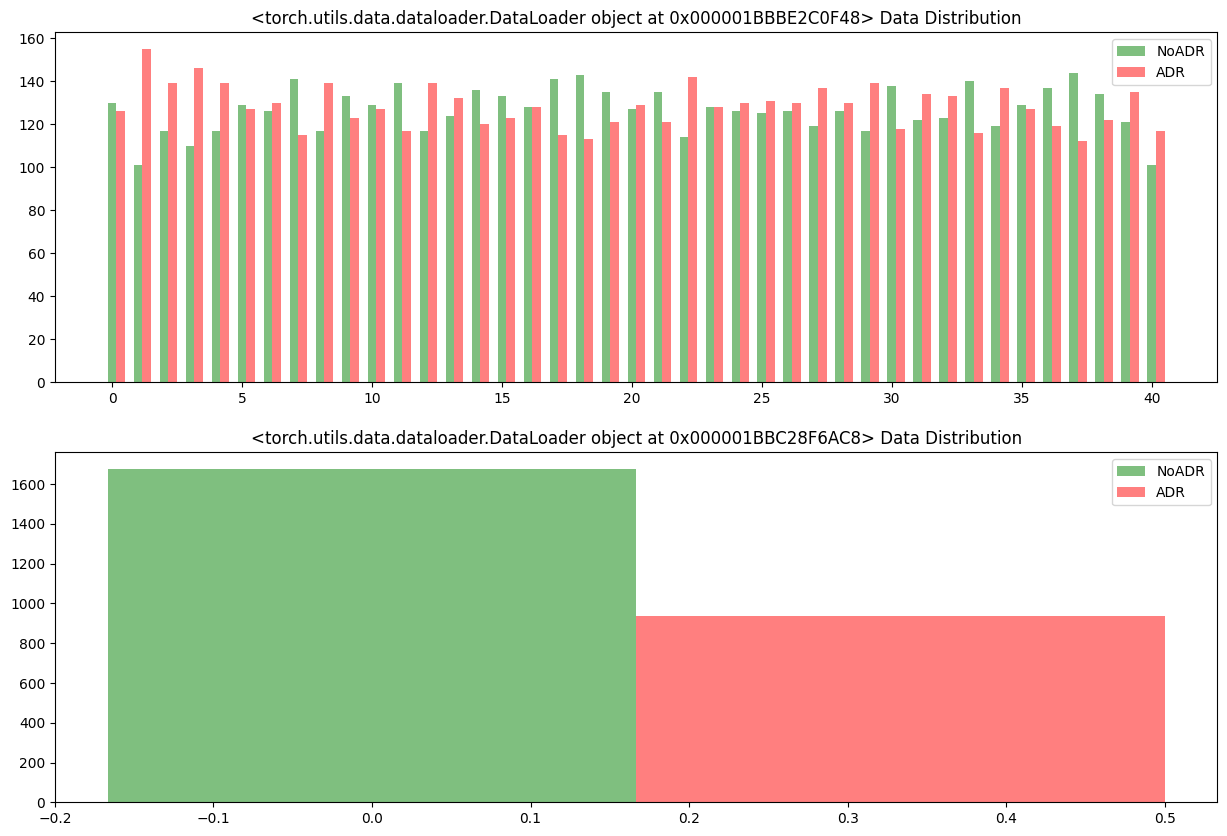

In [13]:
# Empty CUDA cache
torch.cuda.empty_cache()

# Assign device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def define_model(trial):

    # Roughly optimize batch size 32, 64, 128
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256, 512, 1024, 2048, 4096])
    batch_norm = trial.suggest_categorical("batch_norm",['yes','no'])
    dropout = trial.suggest_categorical("dropout",['yes','no'])
    global weightdecay
    weightdecay = trial.suggest_categorical("weightdecay",['yes','no'])
    global train_loader
    global test_loader
    train_loader, test_loader = get_dataloaders(batch_size)
    get_dataloader_distribution(train_loader,test_loader)


    # Optimize number of layer
    n_layers = trial.suggest_int("n_layers", 1,6) #อย่าลืมบวก 1 เพราะ append ไปก่อนเข้า loop แล้ว
    if dropout == 'yes':
        p = trial.suggest_float("dropout_l", 0.1, 0.4) 
    #p = DROPOUT_RATE
    layers = []

    in_features = train_loader.dataset.tensors[0].shape[1]
    #out_features = 256
    out_features = trial.suggest_categorical("n_first_units", [256,512,1024,2048, 4096])

    layers.append(nn.Linear(in_features, out_features))
    layers.append(nn.ReLU())
    if dropout == 'yes':
        layers.append(nn.Dropout(p))
    
    in_features = out_features

    for i in range(n_layers): #i หมายถึงเลขชั้น hidden+1
        #out_features = trial.suggest_int("n_units_l{}".format(i), 5, 4096) 
        #out_features = trial.suggest_int("n_units_l{}".format(i), 256, 2048, 256) 
        if batch_norm == 'yes':
            layers.append(nn.BatchNorm1d(in_features))
        out_features = int(in_features/2)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        if dropout == 'yes':
            layers.append(nn.Dropout(p))
        in_features = out_features

    #layers.append(nn.Linear(in_features, 2048)) #เพิ่มเพ่อบังคับให้ layer สุดท้าย 2048 ตามผลของ optuna
    #layers.append(nn.ReLU()) 
    if batch_norm == 'yes':
        layers.append(nn.BatchNorm1d(in_features))                          
    layers.append(nn.Linear(out_features, classes)) 
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

def objective(trial):

    # Generate the model.
    model = define_model(trial).to(device)
    
    print(model)
    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam"]) #ให้เลือกแค่ Adam อย่างเดียว ไม่ได้ลบไว้เพราะเผื่อจะใส่ SGD ให้ optuna ลองเลือก
    lr = trial.suggest_float("lr", 1e-6, 1e-4, log=True)
    #lr = LEARNING_RATE #ใช้ lr ที่ define ไว้ (ไม่ต้อง optimize)
    if weightdecay == 'yes':
        L2lambda = trial.suggest_float("L2lambda", 1e-3, 1e-1, log=True)
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=L2lambda) #เพิ่ม weight decay เพื่อให้ model ไม่ overfit
    else:
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr) #เพิ่ม weight decay เพื่อให้ model ไม่ overfit
    #ใช้ L2lambda ที่ define ไว้ (ไม่ต้อง optimize)
    
    run_name = "trial-%d" % trial.number
    run_dir = os.path.join(dirname, run_name) # This is the dir used in tensorboard_callback of optuna

    # Tensorboard Integration
    #writer = SummaryWriter(log_dir = f"{run_dir}")
    
    # Training of the model.
    for epoch in range(EPOCHS):
        running_loss = []
        running_train_acc = []
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):



            data = data.float().to(device)
            target = target.float().to(device)

            #with torch.no_grad():
            if epoch == 0 and batch_idx == 0:
                dot = torchviz.make_dot(model(data), show_attrs=True, show_saved = True,params=dict(model.named_parameters()))
                #dot.format = "png"
                dot.render(f'{dirname}/{run_name}_model')

            optimizer.zero_grad()
            output = model(data)
            output = output.flatten()
            
            loss = loss_fn(output,target)
            loss.backward()
            optimizer.step()
    
            running_loss.append(loss.item()) 

            with torch.no_grad():
                target = target.flatten()
                output = torch.round(output)
                correct = (output == target).sum().item()
                train_acc = correct/len(target)
                train_acc = round(train_acc, 8)
                running_train_acc.append(train_acc)
        train_acc = np.mean(running_train_acc)
        train_loss = np.mean(running_loss)
        
        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):

                data = data.float().to(device)
                target = target.float().to(device)               
                output = model(data)
                output = output.flatten()
                #data = data.flatten()
                test_loss = loss_fn(output, target)
                output = torch.round(output)
                correct = (output == target).sum().item()
                
            test_acc = correct / len(test_loader.dataset) #min(len(test_loader.dataset),N_VALID_EXAMPLES)
            
            output = output.cpu().detach().numpy()
            target = target.cpu().detach().numpy()
        
            test_loss = test_loss.cpu().detach().numpy()
   
            test_precision = precision_score(output, target, zero_division=0)
            test_f1_score = f1_score(output, target, zero_division=0)
            test_recall_score = recall_score(output, target, zero_division=0)

        
        print(f"epoch{epoch}, train accuracy: {train_acc}, test accuracy:{test_acc} train loss:{round(train_loss,8)}, test loss:{round(test_loss.item(),8)}, test precision: {test_precision},test recall: {test_recall_score},test f1: {test_f1_score}")
        with tf.summary.create_file_writer(f"{run_dir}_train").as_default():
            tf.summary.scalar("loss", train_loss, step=epoch)
            tf.summary.scalar("acc", train_acc, step=epoch)
        with tf.summary.create_file_writer(f"{run_dir}_test").as_default():    
            tf.summary.scalar("loss", test_loss, step=epoch) 
            tf.summary.scalar("acc", test_acc, step=epoch)
            tf.summary.scalar("precision", test_precision, step=epoch)
            tf.summary.scalar("f1_score", test_f1_score, step=epoch)
            tf.summary.scalar("recall_score", test_recall_score, step=epoch)
            trial.report(test_loss, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    #หากรันจบให้เซฟโมเดลเก็บไว้ด้วยจร้า
    torch.save(model.state_dict(),f"../4 - Training & Testing/{dirname}/{'trial-%d_model.pt' % trial.number}")
    model_tosave = torch.jit.script(model)
    model_tosave.save(f"../4 - Training & Testing/{dirname}/{'trial-%d_model.pt' % trial.number}")

    #Close Writer before openning again
    #writer.close()
    
    return train_loss

if __name__ == "__main__":
    tensorboard_callback = TensorBoardCallback(dirname = dirname, metric_name="target")
    pruner = optuna.pruners.HyperbandPruner(min_resource=1, max_resource=EPOCHS, reduction_factor=3)
    study = optuna.create_study(study_name = dirname, directions=["minimize"],sampler=TPESampler(),storage='sqlite:///optuna.sqlite3',pruner=pruner, load_if_exists=True)
    study.optimize(objective, n_trials=19, timeout=None)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


In [18]:
optuna.copy_study(
    from_study_name="optuna_study2",
    from_storage="sqlite:///optuna.sqlite3",
    to_storage="sqlite:///optuna_final.sqlite3",)

[I 2023-04-12 13:50:44,865] A new study created in RDB with name: optuna_study2


In [2]:
study = optuna.load_study(storage="sqlite:///optuna.sqlite3",study_name="optuna_study6(wide_final)")

In [14]:
study.best_params

{'L2lambda': 0.0026570435599015596,
 'batch_norm': 'yes',
 'batch_size': 512,
 'dropout': 'no',
 'lr': 6.801301238867615e-05,
 'n_first_units': 512,
 'n_layers': 4,
 'optimizer': 'Adam',
 'weightdecay': 'yes'}

In [15]:
optuna.visualization.plot_intermediate_values(study)

In [16]:
optuna.visualization.plot_parallel_coordinate(study,params=['batch_norm','batch_size','dropout','n_layers','weightdecay','n_first_units','lr'])

In [16]:
optuna.visualization.plot_optimization_history(study)

# save model (เลิกใช้! เดะค่อยคำนวณ CF matrix กับ PR curve ใหม่ด้วยการโหลด model ที่เก็บไว้แล้วนำ test_loader มาใช้คำนวณ แต่สิ่งสำคัญคือต้องมีกราฟ test train loss ซึ่งเก็บไว้แล้วใน tensorboard)

In [ ]:
# Model Saver
from datetime import datetime
numberofmodel = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

In [ ]:
#calculate accuracy, precision, recall for each index by matching the value of test_tensor (prediction) and test_label (ground truth)
predicted_dict = {}
for x in range(predicted.shape[0]):
    if torch.argmax(test_tensor[0]).item() in predicted_dict.keys():
        predicted_dict[torch.argmax(test_tensor[0]).item()] += 1
    else:
        predicted_dict[torch.argmax(test_tensor[0]).item()] = 1

label_dict = {}
for x in test_loader.dataset:
    if torch.argmax(x[1]).item() in label_dict.keys():
        label_dict[torch.argmax(x[1]).item()] += 1
    else:
        label_dict[torch.argmax(x[1]).item()] = 1
label_dict = dict(sorted(label_dict.items(), key=lambda item: item[0]))

In [ ]:
true_labels = {'No_ADR': 0,
 'ADR_AIU': 1,
 'ADR_Agranulocytosis': 2,
 'ADR_FDE': 3,
 'ADR_Juandice': 4,
 'ADR_MPeruption': 5,
 'ADR_MPexanthema': 6,
 'ADR_SJSI': 7,
 'ADR_SJSII': 8,
 'ADR_TEN': 9}

 #switch true_labels keys an values
true_labels = {v: k for k, v in true_labels.items()}
true_labels

{0: 'No_ADR',
 1: 'ADR_AIU',
 2: 'ADR_Agranulocytosis',
 3: 'ADR_FDE',
 4: 'ADR_Juandice',
 5: 'ADR_MPeruption',
 6: 'ADR_MPexanthema',
 7: 'ADR_SJSI',
 8: 'ADR_SJSII',
 9: 'ADR_TEN'}

In [ ]:
list(df_labels.columns)

['ADR_AIU',
 'ADR_Agranulocytosis',
 'ADR_FDE',
 'ADR_Juandice',
 'ADR_MPeruption',
 'ADR_MPexanthema',
 'ADR_SJSI',
 'ADR_SJSII',
 'ADR_TEN',
 'No_ADR']

In [ ]:
predicted_dict

{9: 2621}

In [ ]:
label_dict

{2: 1, 4: 103, 5: 133, 6: 350, 7: 64, 8: 277, 9: 1693}

In [ ]:
#remove the keys in true_labels that are not the keys in label_dict
true_labels = {k: v for k, v in true_labels.items() if k in label_dict.keys()}
true_labels

{2: 'ADR_Agranulocytosis',
 4: 'ADR_Juandice',
 5: 'ADR_MPeruption',
 6: 'ADR_MPexanthema',
 7: 'ADR_SJSI',
 8: 'ADR_SJSII',
 9: 'ADR_TEN'}

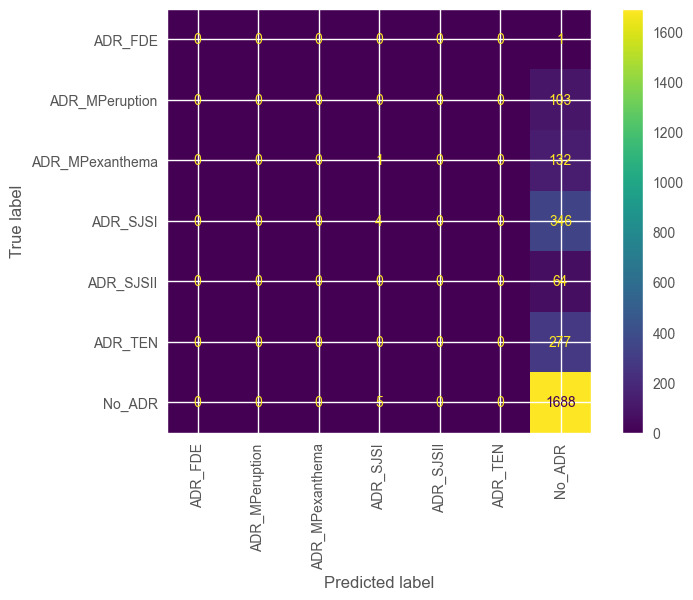

In [ ]:
classes = list(df_labels.columns)

#remove the value in list(df_labels.columns) that got the sum of 0 in df_labels.sum(0)
for x in list(df_labels.columns):
    if df_labels[x].sum(0) == 0:
        classes.remove(x)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn

#classes = true_labels.keys()
#classes = list(df_labels.columns)
cf_matrix = confusion_matrix(test_label[1], predicted)
#df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     #columns = [i for i in classes])
#plt.figure(figsize = (12,7))
#sn.heatmap(df_cm, annot=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=classes)
disp.plot(xticks_rotation=90)
disp.figure_.savefig(f'../4 - Training & Testing/models/model_{numberofmodel}_cf.png')

In [ ]:
from sklearn.metrics import classification_report
cr = classification_report(test_label[1], predicted, target_names=classes)
print(cr)

                 precision    recall  f1-score   support

        ADR_FDE       0.00      0.00      0.00         1
 ADR_MPeruption       0.00      0.00      0.00       103
ADR_MPexanthema       0.00      0.00      0.00       133
       ADR_SJSI       0.40      0.01      0.02       350
      ADR_SJSII       0.00      0.00      0.00        64
        ADR_TEN       0.00      0.00      0.00       277
         No_ADR       0.65      1.00      0.78      1693

       accuracy                           0.65      2621
      macro avg       0.15      0.14      0.12      2621
   weighted avg       0.47      0.65      0.51      2621



c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\harit\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

NameError: name 'allepoch_train_acc' is not defined

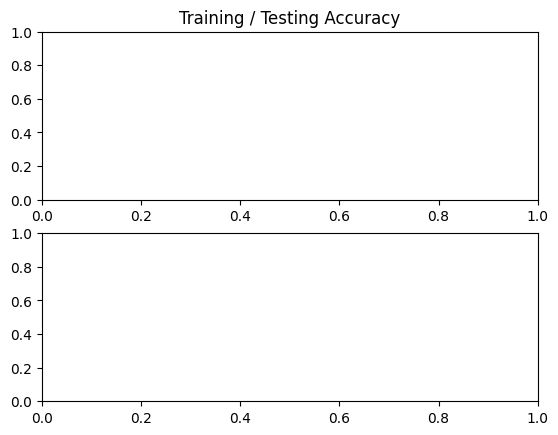

In [11]:
fig, ax = plt.subplots(2,1)
#plt.style.use('ggplot')

ax[0].set_title("Training / Testing Accuracy")
ax[0].plot(allepoch_train_acc, 'red',label='Train',marker='o')
ax[0].plot(allepoch_test_acc,'blue',label='Test',marker='o')
ax[0].xaxis.set(ticks=range(0,len(allepoch_train_acc),1))
ax[0].set_ylabel("Accuracy")
ax[0].legend()
#ax[0].text(4,1,f"Model: {numberofmodel}")


ax[1].set_title("Training loss")
ax[1].set_xlabel("Epochs")
ax[1].plot(allepoch_train_loss,label = 'loss',color='green')
ax[1].plot(allepoch_train_loss,label = 'loss',color='green')
ax[1].xaxis.set(ticks=range(0,len(allepoch_train_acc),1))
ax[1].set_ylabel("Loss")
ax[1].legend()
#plt.show()

plt.tight_layout()#h_pad = 3, w_pad=3)
plt.savefig(f"../4 - Training & Testing/models/model_{numberofmodel}.png")